In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

sys.path.append(os.path.join('..'))

from counting_boats.utils import area_coverage

In [40]:
%cd C:\\ML_Software\\results
coverage = pd.read_csv('coverage.csv')

reference_gon = "C:\\ML_Software\\data\\polygons\\moreton.geojson"

def date_2_udm(date):
    y, m, d = date.split('-')
    fsdate = f"{y}{m}{d}"
    udm = [f for f in os.listdir("UDM") if fsdate in f][0]
    return os.path.join("UDM", udm)

print(coverage.head())
coverage = coverage[coverage['date'] == '2016-04-08']
print(coverage)

for i in range(0, len(coverage)):
    row = coverage.iloc[i]
    poly = row['polygon']
    coverage_n = area_coverage.area_coverage_poly(reference=reference_gon, polygon=poly)
    # put the coverage in the coverage column
    udm = date_2_udm(row["date"])
    cloud_cover, _ = area_coverage.cloud_coverage_udm(udm)
    coverage.iloc[i, coverage.columns.get_loc('area_coverage')] = coverage_n
    coverage.iloc[i, coverage.columns.get_loc('cloud_coverage')] = cloud_cover
    print(row["date"], coverage_n, cloud_cover)

# save the coverage csv again
# coverage.to_csv('coverage.csv', index=False)


C:\ML_Software\results
Empty DataFrame
Columns: [date, aoi, area_coverage, cloud_coverage, polygon, x, y]
Index: []
Empty DataFrame
Columns: [date, aoi, area_coverage, cloud_coverage, polygon, x, y]
Index: []


[0.00142959 0.00276878 0.00553902 0.01133059 0.01258789 0.01346457
 0.02055257 0.02183339 0.02450732 0.07141261 0.08208372 0.09048829
 0.09433864 0.10802067 0.14298678 0.154145   0.16452642 0.19564081
 0.24145389 0.27439724 0.31925399 0.32507776 0.32958911 0.33436812
 0.33908752 0.3414904  0.35457044 0.36008825 0.38441014 0.38530485
 0.39156061 0.39267307 0.39288527 0.39635447 0.39777917 0.47600022
 0.4792332  0.48292665 0.48433528 0.50580029 0.56270262]


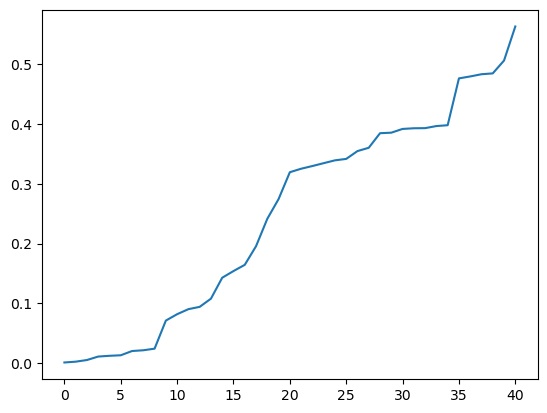

In [30]:
all_cov = coverage['area_coverage'].values
print(all_cov)
fig = plt.figure()  
plt.plot(all_cov)
plt.show()


         date  class                images   latitude   longitude  confidence  \
84 2016-09-10      0  20160910_moreton.tif -27.001374  153.073170    0.848278   
85 2016-09-10      0  20160910_moreton.tif -27.062075  153.141614    0.795723   
86 2016-09-10      0  20160910_moreton.tif -27.066767  153.134449    0.856466   
87 2016-09-10      0  20160910_moreton.tif -27.081559  153.157373    0.737168   
88 2016-09-10      0  20160910_moreton.tif -27.080504  153.156887    0.790635   

           w         h      aoi  
84  6.000010  6.000010  moreton  
85  4.999987  4.999987  moreton  
86  5.727276  6.090917  moreton  
87  3.999998  4.499993  moreton  
88  4.999987  4.999987  moreton  


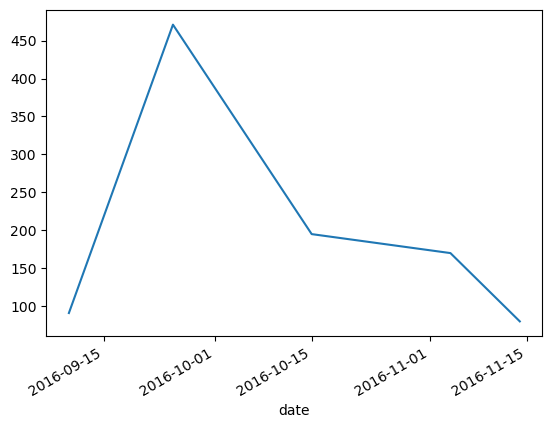

In [12]:
detections = pd.read_csv("C:\\ML_Software\\results\\boat_detections.csv")
detections["date"] = pd.to_datetime(detections["date"], dayfirst=True)
coverage = pd.read_csv("C:\\ML_Software\\results\\coverage.csv")
coverage["date"] = pd.to_datetime(coverage["date"])

over50 = detections[detections["date"].isin(coverage[coverage["area_coverage"] > 0.2]["date"])]
print(over50.head())

# plot count of rows per date
over50["date"].value_counts().sort_index().plot()
plt.show()